In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from torch.utils.data import Dataset
from torchvision import models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
import os
import numpy as np
from torch.utils.data import Subset
from torchvision import transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("the used device is ", device)

the used device is  cuda


In [3]:
def enhance_nuclei(img: Image.Image) -> Image.Image:

    img_np = np.array(img).astype(np.uint8)

    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)

    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced_img = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    return Image.fromarray(enhanced_img)

In [4]:
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: enhance_nuclei(img)),  
    transforms.Resize((64, 64)),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.2)),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),                       
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
val_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

In [6]:
class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        return self.transform(x), y

    def __len__(self):
        return len(self.subset)

In [7]:
data_path = "/kaggle/input/breakhis-breast-cancer-histopathological-dataset/BreakHis - Breast Cancer Histopathological Database/dataset_cancer_v1/dataset_cancer_v1/classificacao_binaria/200X"
dataset = ImageFolder(root=data_path)

patient_to_indices = defaultdict(list)
patient_to_label = {}

for idx, (img_path, class_idx) in enumerate(dataset.samples):
    filename = os.path.basename(img_path)
    patient_id = filename.split("-")[2]  

    patient_to_indices[patient_id].append(idx)
    patient_to_label[patient_id] = class_idx

In [8]:
# Step 2: Stratified split by patient
patient_ids = list(patient_to_indices.keys())
patient_labels = [patient_to_label[pid] for pid in patient_ids]

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_pid_idx, val_pid_idx = next(splitter.split(patient_ids, patient_labels))

train_indices = []
val_indices = []

for i in train_pid_idx:
    pid = patient_ids[i]
    train_indices.extend(patient_to_indices[pid])

for i in val_pid_idx:
    pid = patient_ids[i]
    val_indices.extend(patient_to_indices[pid])

In [9]:
# Step 3: Subsets and loaders
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

train_set = TransformedDataset(train_subset, train_transform)
val_set = TransformedDataset(val_subset, val_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# Validate no leakage
train_pids = set(patient_ids[i] for i in train_pid_idx)
val_pids = set(patient_ids[i] for i in val_pid_idx)
overlap = train_pids.intersection(val_pids)
print(f"✅ Patient overlap: {overlap}")  

✅ Patient overlap: set()


In [10]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # Calculate flattened size after 3 conv+pool layers on 64x64 input
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 64, 64)
            x = self.pool(F.relu(self.bn1(self.conv1(dummy))))
            x = self.pool(F.relu(self.bn2(self.conv2(x))))
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
            self.flatten_dim = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CustomCNN()

In [11]:
import torchvision.models as models

class ResNet50FineTune(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet50FineTune, self).__init__()
        
        # Load pretrained ImageNet weights
        self.model = models.resnet50(weights=None)  # Start from scratch or load offline
        # Example: torch.load("/kaggle/input/pre-trained-models-weights/resnet50-0676ba61.pth")

        # Optional: Freeze early layers
        for name, param in self.model.named_parameters():
            if "layer4" not in name and "fc" not in name:  # only fine-tune last block + fc
                param.requires_grad = False

        # Add a small enhancement block before the fc layer
        # This can learn to adapt features to 64x64 images
        self.enhance = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Replace fc for 2 classes
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.enhance(x)  # enhancement block
        x = self.fc(x)
        return x

resnet50_model = ResNet50FineTune().to(device)

In [12]:
class VGG16FineTune(nn.Module):
    def __init__(self, num_classes=2, fine_tune=True):
        super(VGG16FineTune, self).__init__()
        self.model = models.vgg16(weights=None)  # load pretrained .pth manually if available

        # Freeze features if not fine-tuning
        if not fine_tune:
            for param in self.model.features.parameters():
                param.requires_grad = False

        # Compute flattened feature size for 64x64 input
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 64, 64)
            x = self.model.features(dummy)
            self.flatten_dim = x.view(1, -1).shape[1]

        # Add enhancement block
        self.enhance = nn.Sequential(
            nn.Linear(self.flatten_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Replace classifier
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model.features(x)
        x = torch.flatten(x, 1)
        x = self.enhance(x)
        x = self.fc(x)
        return x

vgg16_model = VGG16FineTune(fine_tune=True).to(device)

In [13]:
from torchvision.models import efficientnet_b0

class EfficientNetB0FineTune(nn.Module):
    def __init__(self, num_classes=2, fine_tune=True):
        super(EfficientNetB0FineTune, self).__init__()
        self.model = efficientnet_b0(weights=None)  # load pretrained .pth manually if available

        # Freeze early layers if not fine-tuning
        if not fine_tune:
            for name, param in self.model.features.named_parameters():
                param.requires_grad = False

        # Enhancement block before classifier
        in_features = self.model.classifier[1].in_features
        self.enhance = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model.features(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.enhance(x)
        x = self.fc(x)
        return x

efficientnet_model = EfficientNetB0FineTune(fine_tune=True).to(device)

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):

    model.to(device)
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history["train_loss"].append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        history["val_loss"].append(epoch_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}")

    return model, history

In [15]:
targets = [dataset.targets[i] for i in train_indices]
class_counts = Counter(targets)
total_samples = sum(class_counts.values())
weights = [total_samples / class_counts[i] for i in range(len(class_counts))]
weights = torch.tensor(weights, dtype=torch.float).to(device) 

In [16]:
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

custom_model, custom_model_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20
)

Epoch [1/20], Train Loss: 0.5724, Val Loss: 0.3500
Epoch [2/20], Train Loss: 0.5012, Val Loss: 0.4746
Epoch [3/20], Train Loss: 0.4682, Val Loss: 0.4024
Epoch [4/20], Train Loss: 0.4719, Val Loss: 0.3184
Epoch [5/20], Train Loss: 0.4416, Val Loss: 0.3471
Epoch [6/20], Train Loss: 0.4306, Val Loss: 0.3506
Epoch [7/20], Train Loss: 0.4405, Val Loss: 0.3426
Epoch [8/20], Train Loss: 0.4248, Val Loss: 0.3221
Epoch [9/20], Train Loss: 0.4231, Val Loss: 0.3143
Epoch [10/20], Train Loss: 0.4075, Val Loss: 0.3793
Epoch [11/20], Train Loss: 0.4071, Val Loss: 0.3788
Epoch [12/20], Train Loss: 0.4424, Val Loss: 0.3764
Epoch [13/20], Train Loss: 0.4098, Val Loss: 0.3796
Epoch [14/20], Train Loss: 0.4063, Val Loss: 0.4701
Epoch [15/20], Train Loss: 0.3820, Val Loss: 0.3810
Epoch [16/20], Train Loss: 0.3936, Val Loss: 0.3848
Epoch [17/20], Train Loss: 0.3845, Val Loss: 0.4246
Epoch [18/20], Train Loss: 0.4047, Val Loss: 0.3781
Epoch [19/20], Train Loss: 0.3727, Val Loss: 0.3679
Epoch [20/20], Train 

In [17]:
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

resnet50_model, resnet50_history = train_model(
    model=resnet50_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20
)

Epoch [1/20], Train Loss: 0.8976, Val Loss: 0.7169
Epoch [2/20], Train Loss: 0.6765, Val Loss: 0.5285
Epoch [3/20], Train Loss: 0.6457, Val Loss: 0.4520
Epoch [4/20], Train Loss: 0.6147, Val Loss: 0.4714
Epoch [5/20], Train Loss: 0.6098, Val Loss: 0.4103
Epoch [6/20], Train Loss: 0.6131, Val Loss: 0.4398
Epoch [7/20], Train Loss: 0.6090, Val Loss: 0.4123
Epoch [8/20], Train Loss: 0.5914, Val Loss: 0.3615
Epoch [9/20], Train Loss: 0.5988, Val Loss: 0.3770
Epoch [10/20], Train Loss: 0.5824, Val Loss: 0.4150
Epoch [11/20], Train Loss: 0.5865, Val Loss: 0.4201
Epoch [12/20], Train Loss: 0.5965, Val Loss: 0.4662
Epoch [13/20], Train Loss: 0.5721, Val Loss: 0.4125
Epoch [14/20], Train Loss: 0.5722, Val Loss: 0.4432
Epoch [15/20], Train Loss: 0.5768, Val Loss: 0.3675
Epoch [16/20], Train Loss: 0.5697, Val Loss: 0.3804
Epoch [17/20], Train Loss: 0.5677, Val Loss: 0.3882
Epoch [18/20], Train Loss: 0.5740, Val Loss: 0.3647
Epoch [19/20], Train Loss: 0.5686, Val Loss: 0.3800
Epoch [20/20], Train 

In [18]:
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

vgg16_model, vgg16_history = train_model(
    model=vgg16_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20
)


Epoch [1/20], Train Loss: 0.7111, Val Loss: 0.6921
Epoch [2/20], Train Loss: 0.6932, Val Loss: 0.6913
Epoch [3/20], Train Loss: 0.6936, Val Loss: 0.6920
Epoch [4/20], Train Loss: 0.6940, Val Loss: 0.6913
Epoch [5/20], Train Loss: 0.6932, Val Loss: 0.6918
Epoch [6/20], Train Loss: 0.7001, Val Loss: 0.6918
Epoch [7/20], Train Loss: 0.6933, Val Loss: 0.6907
Epoch [8/20], Train Loss: 0.7068, Val Loss: 0.6926
Epoch [9/20], Train Loss: 0.7341, Val Loss: 0.6907
Epoch [10/20], Train Loss: 0.6946, Val Loss: 0.6908
Epoch [11/20], Train Loss: 0.7359, Val Loss: 0.6919
Epoch [12/20], Train Loss: 0.7162, Val Loss: 0.6923
Epoch [13/20], Train Loss: 0.7003, Val Loss: 0.6927
Epoch [14/20], Train Loss: 0.6933, Val Loss: 0.6979
Epoch [15/20], Train Loss: 0.6937, Val Loss: 0.6928
Epoch [16/20], Train Loss: 0.6932, Val Loss: 0.6923
Epoch [17/20], Train Loss: 0.6931, Val Loss: 0.6917
Epoch [18/20], Train Loss: 0.7145, Val Loss: 0.6922
Epoch [19/20], Train Loss: 0.6933, Val Loss: 0.6926
Epoch [20/20], Train 

In [19]:
optimizer = optim.Adam(efficientnet_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

efficientnet_model, efficientnet_history = train_model(
    model=efficientnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20
)

Epoch [1/20], Train Loss: 0.6776, Val Loss: 0.6947
Epoch [2/20], Train Loss: 0.5324, Val Loss: 0.3781
Epoch [3/20], Train Loss: 0.5296, Val Loss: 0.4254
Epoch [4/20], Train Loss: 0.5162, Val Loss: 0.3421
Epoch [5/20], Train Loss: 0.4818, Val Loss: 0.4281
Epoch [6/20], Train Loss: 0.4887, Val Loss: 0.5763
Epoch [7/20], Train Loss: 0.4687, Val Loss: 0.5516
Epoch [8/20], Train Loss: 0.4933, Val Loss: 0.3565
Epoch [9/20], Train Loss: 0.4795, Val Loss: 0.4165
Epoch [10/20], Train Loss: 0.4742, Val Loss: 0.4589
Epoch [11/20], Train Loss: 0.5119, Val Loss: 0.3951
Epoch [12/20], Train Loss: 0.4655, Val Loss: 0.4566
Epoch [13/20], Train Loss: 0.4519, Val Loss: 0.3866
Epoch [14/20], Train Loss: 0.4502, Val Loss: 0.5266
Epoch [15/20], Train Loss: 0.4844, Val Loss: 0.3825
Epoch [16/20], Train Loss: 0.4290, Val Loss: 0.4207
Epoch [17/20], Train Loss: 0.4301, Val Loss: 0.6642
Epoch [18/20], Train Loss: 0.4839, Val Loss: 0.8529
Epoch [19/20], Train Loss: 0.4641, Val Loss: 0.5621
Epoch [20/20], Train 

In [20]:
def evaluate_model(model, val_loader, device):

    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")
    return val_acc, all_preds, all_labels


Validation Accuracy: 81.21%

=== CustomCNN Classification Report ===
              precision    recall  f1-score   support

      benign       0.73      0.78      0.75       170
   malignant       0.87      0.83      0.85       293

    accuracy                           0.81       463
   macro avg       0.80      0.81      0.80       463
weighted avg       0.82      0.81      0.81       463

Validation Accuracy: 87.90%

=== ResNet50 Classification Report ===
              precision    recall  f1-score   support

      benign       0.93      0.72      0.81       170
   malignant       0.86      0.97      0.91       293

    accuracy                           0.88       463
   macro avg       0.89      0.85      0.86       463
weighted avg       0.89      0.88      0.88       463

Validation Accuracy: 63.28%

=== VGG16 Classification Report ===
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       170
   malignant       0.63      1.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy: 76.89%

=== EfficientNet Classification Report ===
              precision    recall  f1-score   support

      benign       0.65      0.81      0.72       170
   malignant       0.87      0.75      0.80       293

    accuracy                           0.77       463
   macro avg       0.76      0.78      0.76       463
weighted avg       0.79      0.77      0.77       463



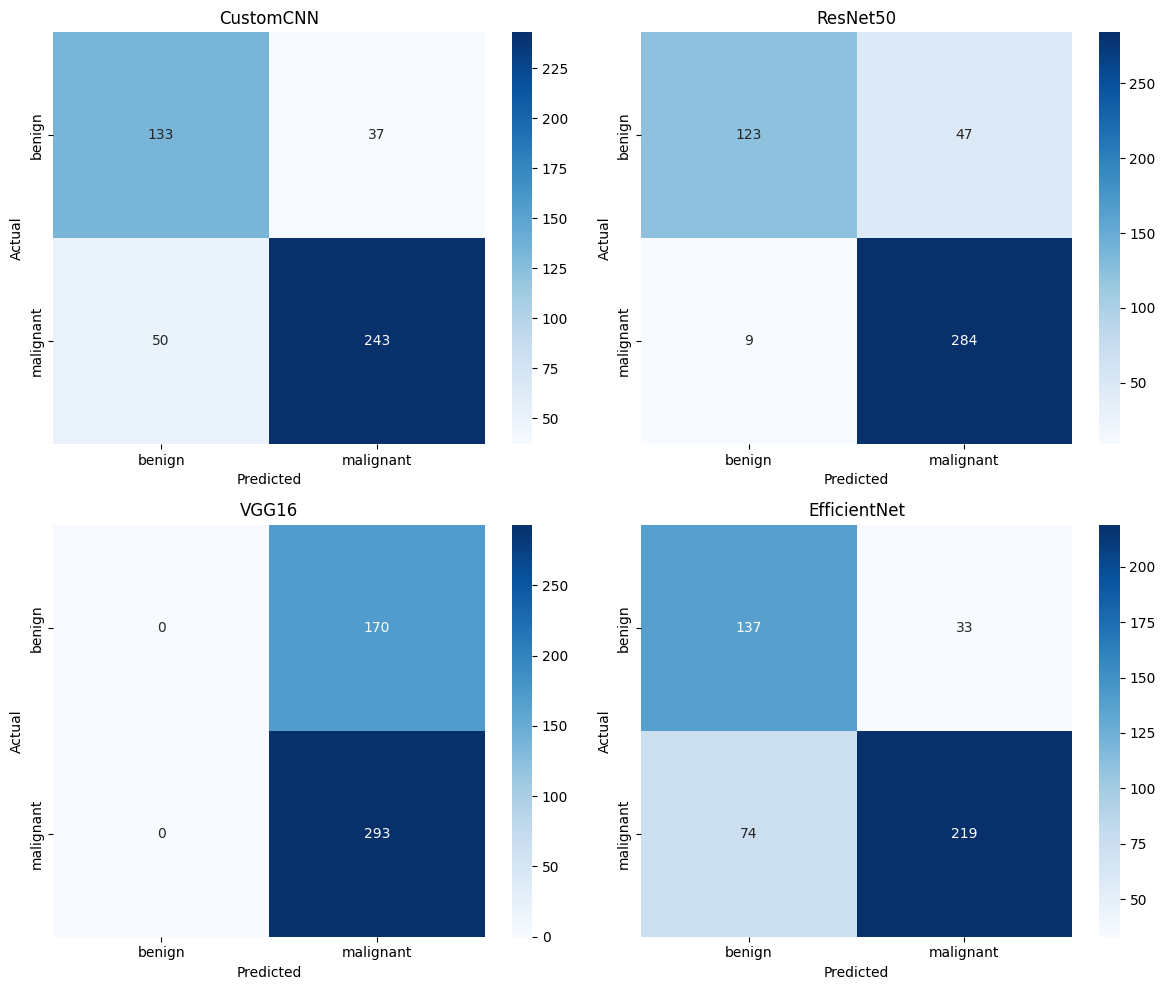

In [21]:
models_list = [
    ("CustomCNN", custom_model),
    ("ResNet50", resnet50_model),
    ("VGG16", vgg16_model),
    ("EfficientNet", efficientnet_model)
]

class_names = dataset.classes  # ['benign', 'malignant']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid
axes = axes.flatten()

for i, (name, model) in enumerate(models_list):
    # Evaluate model
    val_acc, all_preds, all_labels = evaluate_model(model, val_loader, device)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print classification report
    print(f"\n=== {name} Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot confusion matrix in subplot
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, 
                yticklabels=class_names, ax=axes[i])
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    axes[i].set_title(f"{name}")

plt.tight_layout()
plt.show()